In [2]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation of bin coverage

In [6]:
def load_bin_coverate(path):
    sample = path.split("/")[-1][:-4]
    ks, vs = list(), list()
    with open(path) as f:
        for line in f:
            row = line.strip("\n").split("\t")
            k = "%s_%s_%s" % (row[0], row[1], row[2])
            v = float(row[3])
            if v > 0:
                ks.append(k)
                vs.append(v)
    s = pd.Series(vs, index=ks)
    s.name = sample
    return s

array = []
for path in sorted(glob.glob("results/03_tracks/02_bin_coverage/*.txt")):
    array.append(load_bin_coverate(path))
    # break

In [11]:
d = pd.concat(array, axis=1).fillna(0)
d.shape

(2135018, 32)

In [14]:
corr = d.corr()

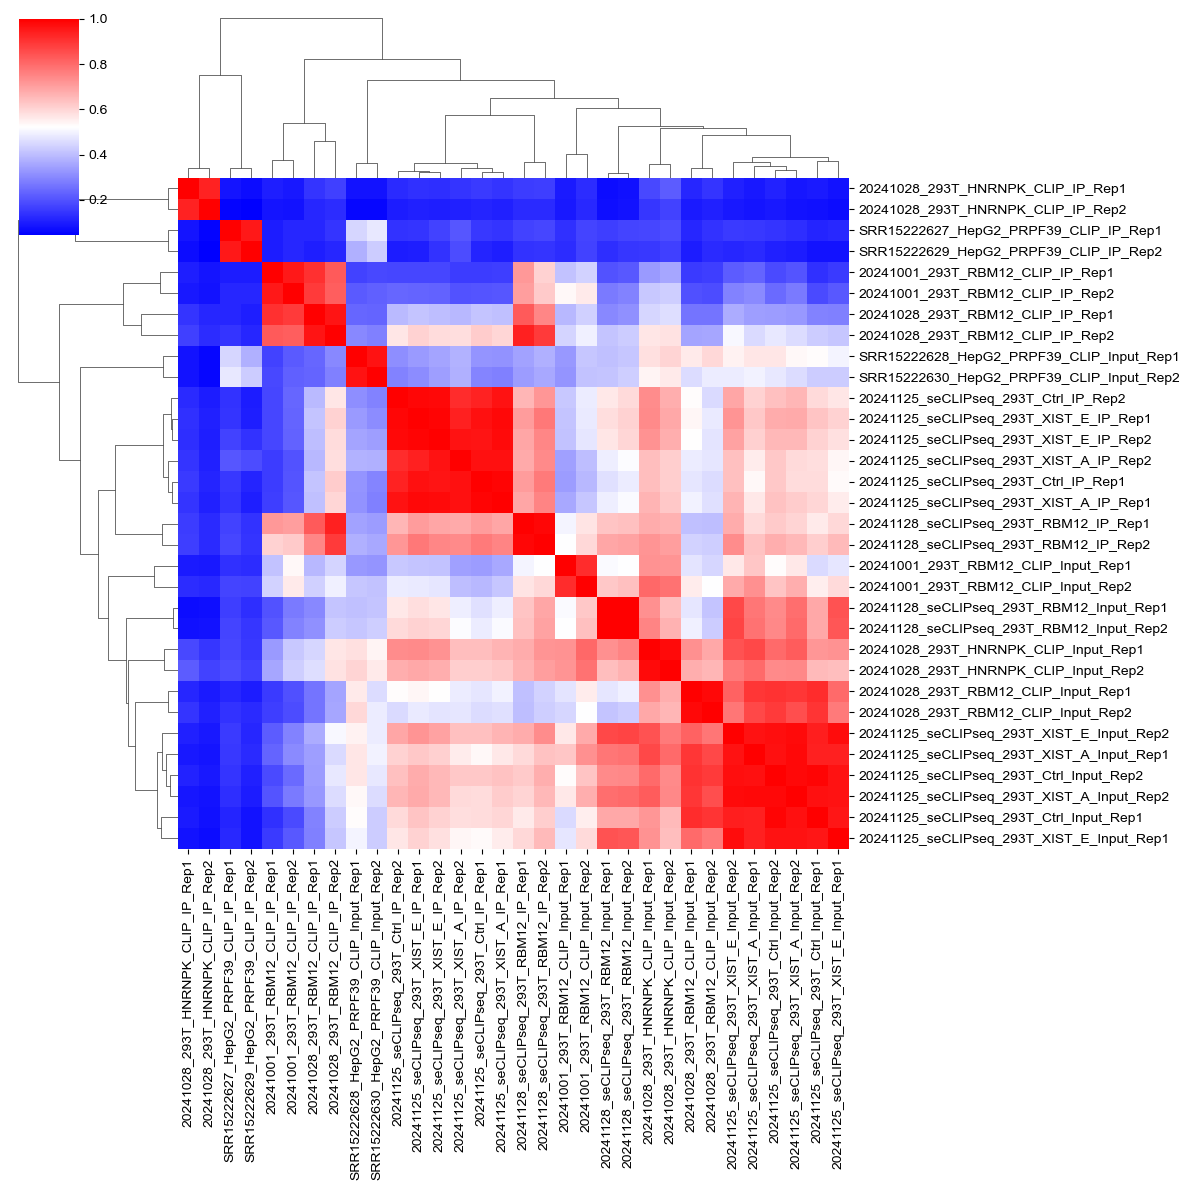

In [24]:
ret = sns.clustermap(corr, figsize=(12, 12), cmap="bwr")
ret.fig.savefig("figures/correlation_of_bin_coverage_clustermap.pdf")

# Peak sequences and sgRNA target sequences

In [50]:
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import edlib
from Bio.Seq import Seq
from pyBioInfio
from pyBioInfo.IO.File import BedFile, FastaFile

In [70]:
def align(query, reference):
    a = edlib.align(query, reference, task="locations", mode="HW")
    ed = a["editDistance"]
    start, end = a["locations"][0]
    end += 1
    return start, end, ed
        
array = []
for name in ["20241125_seCLIPseq_293T_Ctrl", "20241125_seCLIPseq_293T_XIST_A", "20241125_seCLIPseq_293T_XIST_E"]:
    bedfile = "results/05_merged_rep_peaks/%s/01v02.idr.out.bed" % name
    # bedfile = "results/02_peaks/01_clipper/%s_IP_Rep1.bed.gz" % name
    fafile = "/home/chenzonggui/species/homo_sapiens/GRCh38.p13/GRCh38.canonical.genome.fa"
    peaks = []
    with BedFile(bedfile) as f, FastaFile(fafile, random=True) as fasta:
        for peak in f:
            try:
                peak.seq = fasta.fast_fetch(obj=peak).upper()
                peaks.append(peak)
            except KeyError:
                # print(peak.format())
                pass

    for sgrna in ["XIST-A", "XIST-E"]:
        if sgrna == "XIST-A":
            sgrna_f = "GGTACACCAGGTGTTTTCAAGGTCTTTTCA"
        else:
            sgrna_f = "TCCCACCCATTATACATGAACCCCTCTACT"
        print("-" * 80)
        print(name)
        print(sgrna)
        sgrna_r = str(Seq(sgrna_f).reverse_complement())
        # print(sgrna_f)
        # print(sgrna_r)

        rows = []
        for peak in peaks:
            x1, y1, ed1 = align(sgrna_f, peak.seq)
            x2, y2, ed2 = align(sgrna_r, peak.seq)
            if ed1 <= ed2:
                x, y, ed, direction = x1, y1, ed1, "F"
            else:
                x, y, ed, direction = x2, y2, ed2, "R"
            row = [peak.chrom, peak.start, peak.end, x, y, ed, direction, peak.seq]
            rows.append(row)
        
        columns = ["Chrom", "Start", "End", "X", "Y", "ED", "Direction", "Sequence"]
        d = pd.DataFrame(rows, columns=columns)
        array.append([name, sgrna, Counter(d["ED"])])
        # plt.figure(figsize=(3, 3))
        # ret = plt.hist(d["ED"], range=(0, 50), bins=50, edgecolor="black")
        # array.append([name, sgrna, ret])
        # plt.xlabel("Edit distance")
        # plt.ylabel("Number of peaks")
        # plt.tight_layout()
        # plt.show()

--------------------------------------------------------------------------------
20241125_seCLIPseq_293T_Ctrl
XIST-A
--------------------------------------------------------------------------------
20241125_seCLIPseq_293T_Ctrl
XIST-E
--------------------------------------------------------------------------------
20241125_seCLIPseq_293T_XIST_A
XIST-A
--------------------------------------------------------------------------------
20241125_seCLIPseq_293T_XIST_A
XIST-E
--------------------------------------------------------------------------------
20241125_seCLIPseq_293T_XIST_E
XIST-A
--------------------------------------------------------------------------------
20241125_seCLIPseq_293T_XIST_E
XIST-E


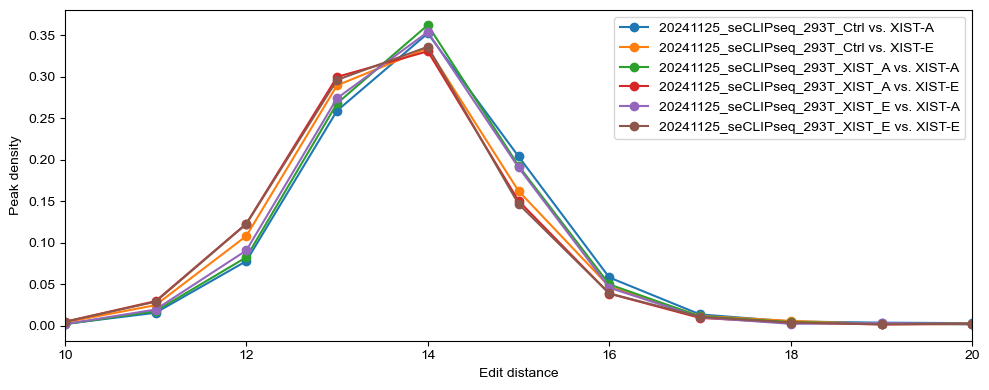

In [72]:
plt.figure(figsize=(10, 4))
for name, sgrna, counter in array:
    xs = np.arange(0, 30)
    ys = np.array([counter[x] for x in xs])
    ys = ys / sum(counter.values())
    plt.plot(xs, ys, marker="o", label="%s vs. %s" % (name, sgrna))
plt.xlim(10, 20)
plt.xlabel("Edit distance")
plt.ylabel("Peak density")
plt.legend()
plt.tight_layout()
plt.show()

In [1]:
import yaml
with open("config.yaml") as f:
    samples = yaml.load(f, Loader=yaml.BaseLoader)["SAMPLES"]

In [5]:
rows = []
for sample in samples:
    path1 = "results/01_pipeline/08_sorted_bam/%s.byPos.flagstat" % sample
    n1 = int(open(path1).readlines()[0].split()[0])
    path2 = "results/01_pipeline/09_dedup/%s.dedup.sorted.flagstat" % sample
    n2 = int(open(path2).readlines()[0].split()[0])
    rows.append([sample, n1, n2])

In [6]:
import pandas as pd

In [13]:
d = pd.DataFrame(rows, columns=["Sample", "Reads", "UniqReads"])
d["DupReads"] = d["Reads"] - d["UniqReads"]
d["DupRatio"] = d["DupReads"] / d["Reads"]
d.to_csv("duplicate_summary.csv", index=False)

In [1]:
# 

# Processing replicated peaks

In [3]:
from pyBioInfo.IO.File import BedFile

In [4]:
with BedFile("results/5_merged_rep_peaks/1_peaks/20241028_293T_HNRNPK_CLIP/01v02.idr.out.bed") as f:
    peaks = list(sorted(f))
with open("results/20241028_293T_HNRNPK_CLIP.bed", "w+") as fw:
    for peak in peaks:
        fw.write(peak.format("bed") + "\n")
! bgzip -f results/20241028_293T_HNRNPK_CLIP.bed
! tabix -p bed -f results/20241028_293T_HNRNPK_CLIP.bed.gz